### **0. Libraries + Dataset import**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from os import path

In [2]:
# working directory
data_directory = '/Users/lukas/OneDrive/01_Projects/Conduct your own end-to-end analytics project/Code/Upload'

# features
feature_df = pd.read_csv(path.join(data_directory, '20231006_pt_feature.csv'), low_memory=False)

# reviews
review_df = pd.read_csv(path.join(data_directory, '20231006_pt_reviews.csv'), low_memory=False)

# alochol
alcohol_df = pd.read_csv(path.join(data_directory, 'df_alcohol.csv'), low_memory=False)

In [3]:
# first inspection
feature_df.shape

(2500, 32)

In [4]:
# first inspection
review_df.shape

(464109, 19)

In [5]:
review_df.columns

Index(['Unnamed: 0', 'wine_id', 'year', 'review_id', 'user_id', 'user_name',
       'review_rating', 'review', 'createdat', 'review_referring_year',
       'likes_on_review', 'comments_on_review', 'user_language',
       'user_follower', 'user_following', 'user_total_given_ratings',
       'user_total_sum_ratings', 'user_total_given_reviews',
       'user_purchase_made'],
      dtype='object')

In [6]:
# create an really unique identifier 
review_df['identifier'] = review_df.apply(lambda row: f"{row['review_id']}-{row['createdat']}", axis=1)

In [7]:
review_df.drop_duplicates(subset=['identifier'], inplace=True)

review_df.drop(columns='identifier', inplace=True)

In [8]:
review_df.shape

(260158, 19)

In [9]:
# first inspection
alcohol_df.shape

(2500, 4)

In [10]:
# create unique identifier based on the combination wine_id and year
feature_df['unique_id'] = feature_df.apply(lambda row: f"{row['wine_id']}-{row['year']}", axis=1)

In [11]:
# replace na year with nan review_reffering year with original year
review_df.loc[review_df['review_referring_year'].isnull() & review_df['year'].notnull(), 'review_referring_year'] = review_df.loc[review_df['review_referring_year'].isnull() & review_df['year'].notnull(), 'year']

In [12]:
# create unique identifier based on the combination wine_id and year
review_df['unique_id'] = review_df.apply(lambda row: f"{row['wine_id']}-{row['review_referring_year']}", axis=1)

In [13]:
# define a list for unique identifier for reviews
wine_review_list = list(np.unique(review_df['unique_id']))

# define a list for unique identifier for features 
wine_feature_list = list(np.unique(feature_df['unique_id']))

In [14]:
# just include wine with their features who have a review
feature_df = feature_df[feature_df['unique_id'].isin(wine_review_list)]

# just include wine with their features who have a review
review_df = review_df[review_df['unique_id'].isin(wine_feature_list)]

In [15]:
# adjusted final inspection
feature_df.shape

(2354, 33)

In [16]:
# adjusted final inspection
review_df.shape

(81993, 20)

In [17]:
# add alcohol
feature_df = feature_df.merge(alcohol_df, how='left')

### **1. Data cleaning and preparation of the independt dataframes**

In [18]:
# drop non-meaningful columns 
feature_df.drop(columns=['Unnamed: 0', 'seo-name', 'vintage_id','genre', 'seo_cleaned', 'country', 'body_rating'], axis = 1, inplace=True)

# rename columns for spelling correction & consistency
feature_df.rename({'suggested_food_pairining': 'suggested_food_pairing','total_number_ratings': 'total_ratings_number' }, axis=1, inplace =True)

In [19]:
# drop non-meaningful columns 
review_df.drop(columns=['Unnamed: 0', 'user_name'], axis=1, inplace=True)

#### a. Missing values

##### feature_df

In [20]:
# check for missing values
null_df = feature_df.isnull().sum().reset_index()
null_df.columns = ['feature', 'value']

# criteria
not_null = null_df['value'] != 0

# output
null_df = null_df[not_null]
null_df["share (%)"] = np.round(null_df["value"]/feature_df.shape[0]*100, 2)
null_df["counter_value"] = np.round(2387-null_df["value"])
null_df.sort_values('share (%)', ascending = False)

,feature,value,share (%),counter_value
23,fizziness,2341,99.45,46
12,original_price,2336,99.24,51
22,tannin,1227,52.12,1160
6,wine_style_description,859,36.49,1528
15,interesting_facts,859,36.49,1528
14,grapes,339,14.40,2048
27,alcohol,214,9.09,2173
20,sweetness,80,3.40,2307
5,wine_style,67,2.85,2320
16,body_description,67,2.85,2320


In [21]:
# exact match for missing values for tannin and fizzines: set the other to cero
feature_df['vivino_type_id'].value_counts()

vivino_type_id
1.0     1127
2.0      582
24.0     531
4.0       34
3.0       13
Name: count, dtype: int64

In [22]:
# sparkling wine with no indicator for sweetness
feature_df['sweetness'] = feature_df['sweetness'].replace(np.nan, 0)

# fizziness only for sparkling wines
feature_df['fizziness'] = feature_df['fizziness'].replace(np.nan, 0)

# tannin only for red wines
feature_df['tannin'] = feature_df['tannin'].replace(np.nan, 0)

In [23]:
# above the threshold of 50 %: drop features
feature_df = feature_df.drop(columns= ['original_price'], axis = 1)

In [24]:
# pattern to check to impute with other value, but not possible
pattern_list = ['wine', 'wine_id','suggested_food_pairing', 'wine_style', 'intensity', 'acidity',
            'vivino_type_id', 'body_description']

# to remove
ids_to_remove = list(np.unique(feature_df[feature_df["intensity"].isnull()][pattern_list]['wine_id']))

# remove
feature_df = feature_df[~feature_df['wine_id'].isin(ids_to_remove)]

In [25]:
# drop observations with missing winery 
ids_to_remove = list(feature_df[feature_df["winery"].isna()][['wine_id', 'wine']]['wine_id'])

feature_df = feature_df[~feature_df['wine_id'].isin(ids_to_remove)]

In [26]:
feature_df['alcohol'] = feature_df['alcohol'].replace(0, np.nan)
feature_df['alcohol']=feature_df['alcohol'].fillna(feature_df.groupby('vivino_type_id')['alcohol'].transform('median'))

In [27]:
# Calculate the mode for each wine_style group
mode_per_style = feature_df.groupby('wine_style')['flavor_words'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Create a DataFrame for easy access
mode_per_style_df = mode_per_style.reset_index().rename(columns={'flavor_words': 'mode_flavor_words'})

# Merge the mode values back to the original DataFrame
feature_df = feature_df.merge(mode_per_style_df, on='wine_style', how='left')

# Replace NaN values in flavor_words with the mode values
feature_df['flavor_words'] = feature_df['flavor_words'].fillna(feature_df['mode_flavor_words'])

# Drop the extra column as it's no longer needed
feature_df.drop(columns=['mode_flavor_words'], inplace=True)

In [28]:
# replace the missing value for grapes with most frequent category
mode_grapes = feature_df['grapes'].mode()[0]
feature_df['grapes'].fillna(mode_grapes, inplace=True)

In [29]:
# to possibility to remove with same category due that fact all are empty
check_to_replace = list(np.unique(feature_df[feature_df['wine_style_description'].isna()][['wine_style','wine_style_description']]['wine_style']))

for i in check_to_replace:
    print(f'{i}: {feature_df[feature_df["wine_style"]==i].shape[0]}')


Central Portugal Red: 110
Central Portugal White: 32
Colheita Port: 59
Crusted Port: 3
Late Bottled Vintage Port: 53
Northern Portugal Rosé: 34
Portuguese Azores Red: 2
Portuguese Azores White: 7
Portuguese Dão White: 65
Portuguese Madeira: 67
Portuguese Moscatel: 12
Portuguese Red: 6
Portuguese Sparkling: 13
Portuguese White: 3
Ruby Port: 30
Single Quinta Vintage Port: 20
Tawny Port: 92
Vintage Port: 143
White Port: 41


In [30]:
# create indicator
feature_df['has_wine_style_description'] = feature_df['wine_style_description'].apply(lambda x: 'No' if pd.isna(x) else 'Yes')

# replace na with empty
feature_df['wine_style_description'] = feature_df['wine_style_description'].fillna('empty')

In [31]:
# create indicator
feature_df['has_interesting_facts'] = feature_df['interesting_facts'].apply(lambda x: 'No' if pd.isna(x) else 'Yes')

# replace na with empty
feature_df['interesting_facts'] = feature_df['interesting_facts'].fillna('empty')

In [32]:
# check for missing values
null_df = feature_df.isnull().sum().reset_index()
null_df.columns = ['feature', 'value']

# criteria
not_null = null_df['value'] != 0

# output
null_df = null_df[not_null]
null_df["share (%)"] = np.round(null_df["value"]/feature_df.shape[0]*100, 2)
null_df

,feature,value,share (%)


##### review_df

In [33]:
# check for missing values
null_df = review_df.isnull().sum().reset_index()
null_df.columns = ['feature', 'value']

# criteria
not_null = null_df['value'] != 0

# output
null_df = null_df[not_null]
null_df["share (%)"] = np.round(null_df["value"]/review_df.shape[0]*100, 2)
null_df.sort_values('share (%)', ascending = False)

,feature,value,share (%)
5,review,2,0.0
10,user_language,2,0.0
11,user_follower,2,0.0
12,user_following,2,0.0
13,user_total_given_ratings,2,0.0
14,user_total_sum_ratings,2,0.0
15,user_total_given_reviews,2,0.0
16,user_purchase_made,2,0.0


In [34]:
review_df = review_df[review_df['review'].notna()]

In [35]:
# check for missing values
null_df = review_df.isnull().sum().reset_index()
null_df.columns = ['feature', 'value']

# criteria
not_null = null_df['value'] != 0

# output
null_df = null_df[not_null]
null_df["share (%)"] = np.round(null_df["value"]/review_df.shape[0]*100, 2)
null_df.sort_values('share (%)', ascending = False)

,feature,value,share (%)


#### b. Duplicates

##### feature_df

In [36]:
# check for occurence of duplicates
feature_df.duplicated().any()

True

In [37]:
# drop duplicates
feature_df = feature_df.drop_duplicates()

In [38]:
# final outcome
feature_df.shape

(1797, 29)

In [39]:
# final check
feature_df.duplicated().any()

False

##### review_df

In [40]:
review_df.shape

(81991, 18)

In [41]:
review_df.drop(columns = 'year', axis =1, inplace = True)

In [42]:
# check for occurence of duplicates
review_df.duplicated().any()

False

In [43]:
review_df = review_df.drop_duplicates()

In [44]:
review_df.shape

(81991, 17)

#### c. Data preprocessing

##### feature_df

In [45]:
# Split the suggested_food_pairing into individual foods and create a set of unique foods
feature_df['suggested_food_pairing'] = feature_df['suggested_food_pairing'].apply(lambda x: [food.strip() for food in x.split(',')])

# Create a set of unique foods after stripping spaces
unique_food = set(food for sublist in feature_df['suggested_food_pairing'] for food in sublist)

# Create True/False columns for each food
for food in unique_food:
    feature_df[food] = feature_df['suggested_food_pairing'].apply(lambda x: food in x)

In [46]:
# number of food_words
feature_df['amount_food_words'] = feature_df['suggested_food_pairing'].apply(lambda x: len(x))

# drop the wrong splitted variables
feature_df.drop(columns = ['venison)', 'tuna etc)'], axis=1, inplace=True)

feature_df.rename({'Rich fish (salmon': 'Rich fish (salmon & tuna etc)','Game (deer':'Game (deer & vension)' }, axis=1, inplace = True)

feature_df.drop(columns = 'suggested_food_pairing', axis=1, inplace=True)

In [47]:
# Split the suggested_food_pairing into individual foods and create a set of unique foods
feature_df['flavor_words'] = feature_df['flavor_words'].apply(lambda x: [flavor.strip() for flavor in x.split(',')])

# Create a set of unique foods after stripping spaces
unique_flavor = set(flavor for sublist in feature_df['flavor_words'] for flavor in sublist)

# Create True/False columns for each food
for flavor in unique_flavor:
    feature_df[flavor] = feature_df['flavor_words'].apply(lambda x: flavor in x)

In [48]:
# number of food_words
feature_df['amount_flavor_words'] = feature_df['flavor_words'].apply(lambda x: len(x))

# drop unecessary column
feature_df.drop(columns = 'flavor_words', axis=1, inplace=True)

In [49]:
# to calcuate the number of grapes but keep the combinations
feature_df['amount_grapes'] = feature_df['grapes'].str.split(', ').apply(len)

In [50]:
# mapping the number Vivino wine ids to specific names
wine_type_mapping = {1.0: "red", 2.0: "white", 24.0: "fortitied", 4.0: "rose", 3.0: "sparkling" }

feature_df["wine_type"] = feature_df["vivino_type_id"].map(wine_type_mapping)

In [51]:
# drop the column ro 
feature_df.drop(columns='vivino_type_id', axis=1, inplace=True)

In [52]:
# make everything in small letters
feature_df.columns = [feature.lower() for feature in feature_df.columns]

##### review_df

In [53]:
review_df.columns

Index(['wine_id', 'review_id', 'user_id', 'review_rating', 'review',
       'createdat', 'review_referring_year', 'likes_on_review',
       'comments_on_review', 'user_language', 'user_follower',
       'user_following', 'user_total_given_ratings', 'user_total_sum_ratings',
       'user_total_given_reviews', 'user_purchase_made', 'unique_id'],
      dtype='object')

In [54]:
# value to replace with just the language
change = {'ru-RU': 'ru', 'pt-PT': 'pt', 'pt-BR': 'pt', 'it-IT': 'it', 'sv-SE': 'sv', 'en-US': 'en', 'fr-FR': 'fr', 'ca-ES': 'ca', 'nl-NL': 'nl', 'ro-RO': 'ro', 'zh-CN': 'zh', 'da-DK': 'da',
            'en-AU': 'en', 'de-DE': 'de', 'ja-JP': 'ja'}
review_df['user_language'] = review_df['user_language'].replace(change)

In [55]:
review_df['review_rating'].value_counts()

review_rating
4.0    28247
3.5    12276
4.5     8801
5.0     8017
3.0     7269
3.8     2129
4.2     1831
3.9     1759
4.1     1581
2.5     1467
3.7     1423
4.3     1132
2.0     1128
3.6      892
4.4      761
1.0      443
3.4      404
4.6      400
3.3      339
4.7      335
4.8      280
3.2      279
1.5      204
4.9      123
3.1      115
2.8       93
2.9       87
2.7       52
2.3       28
2.6       26
2.2       19
2.4       12
2.1        9
1.2        8
1.1        7
1.6        5
1.8        3
1.7        2
1.4        2
1.3        2
1.9        1
Name: count, dtype: int64

In [56]:
sorted_review_df = review_df['review_rating'].value_counts().reset_index().sort_values(by='review_rating')
sorted_review_df['review_rating'] = sorted_review_df['review_rating'].astype(str)

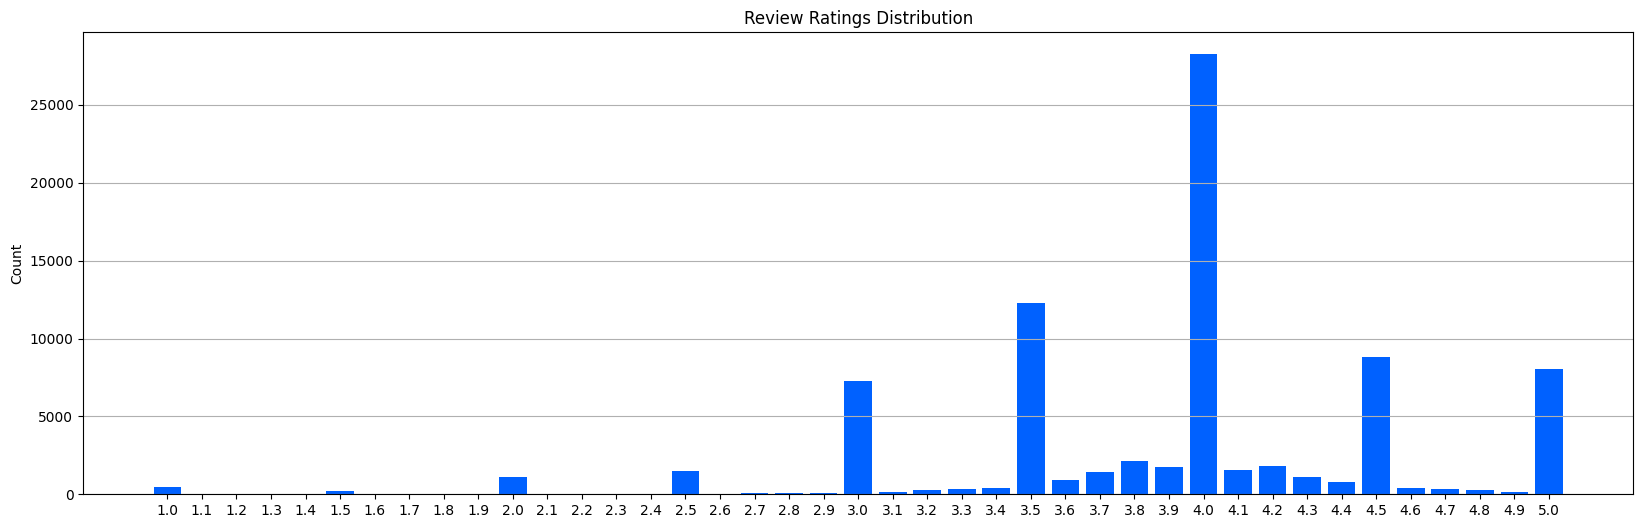

In [57]:
# Plotting
sorted_review_df = review_df['review_rating'].value_counts().reset_index().sort_values(by='review_rating')
sorted_review_df['review_rating'] = sorted_review_df['review_rating'].astype(str)

plt.figure(figsize=(20, 6))
plt.bar(sorted_review_df['review_rating'], sorted_review_df['count'], color='#0061FF')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Review Ratings Distribution')
plt.grid(axis='y')
plt.show()

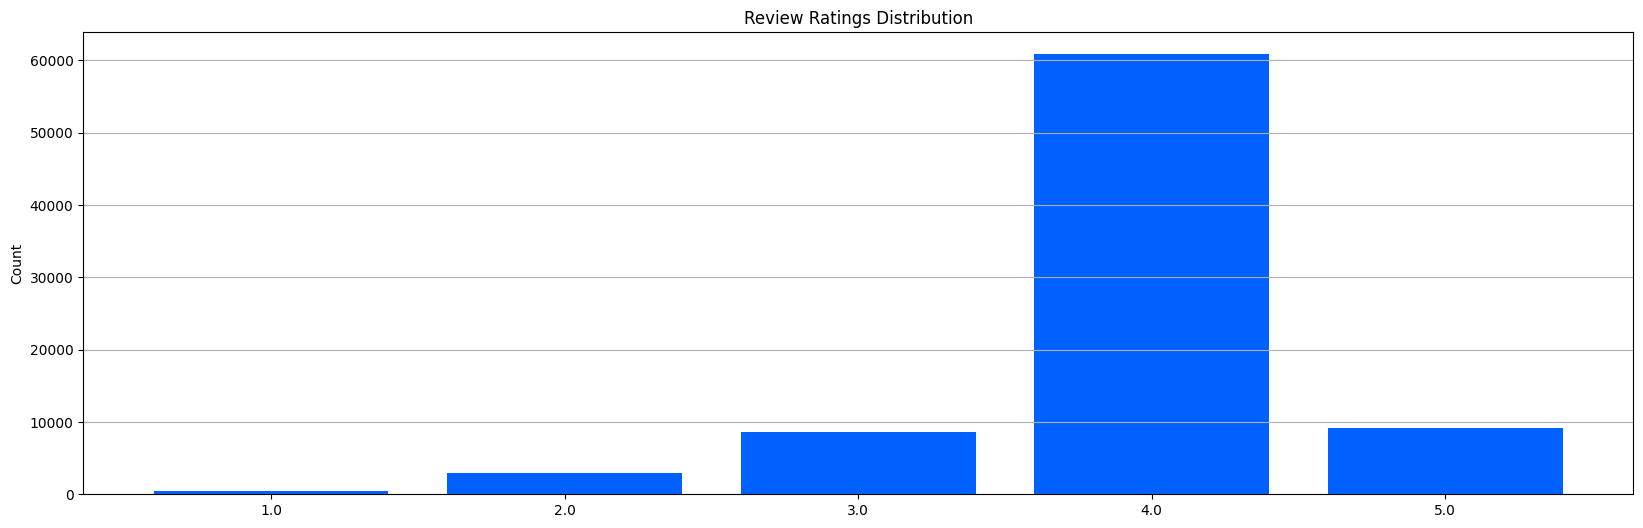

In [58]:
# Plotting
temp_df = review_df.copy()[['review_rating']]
temp_df['review_rating'] = temp_df['review_rating'].apply(lambda values: np.round(values))

sorted_review_df = temp_df['review_rating'].value_counts().reset_index().sort_values(by='review_rating')
sorted_review_df['review_rating'] = sorted_review_df['review_rating'].astype(str)

plt.figure(figsize=(20, 6))
plt.bar(sorted_review_df['review_rating'], sorted_review_df['count'], color='#0061FF')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Review Ratings Distribution')
plt.grid(axis='y')
plt.show()

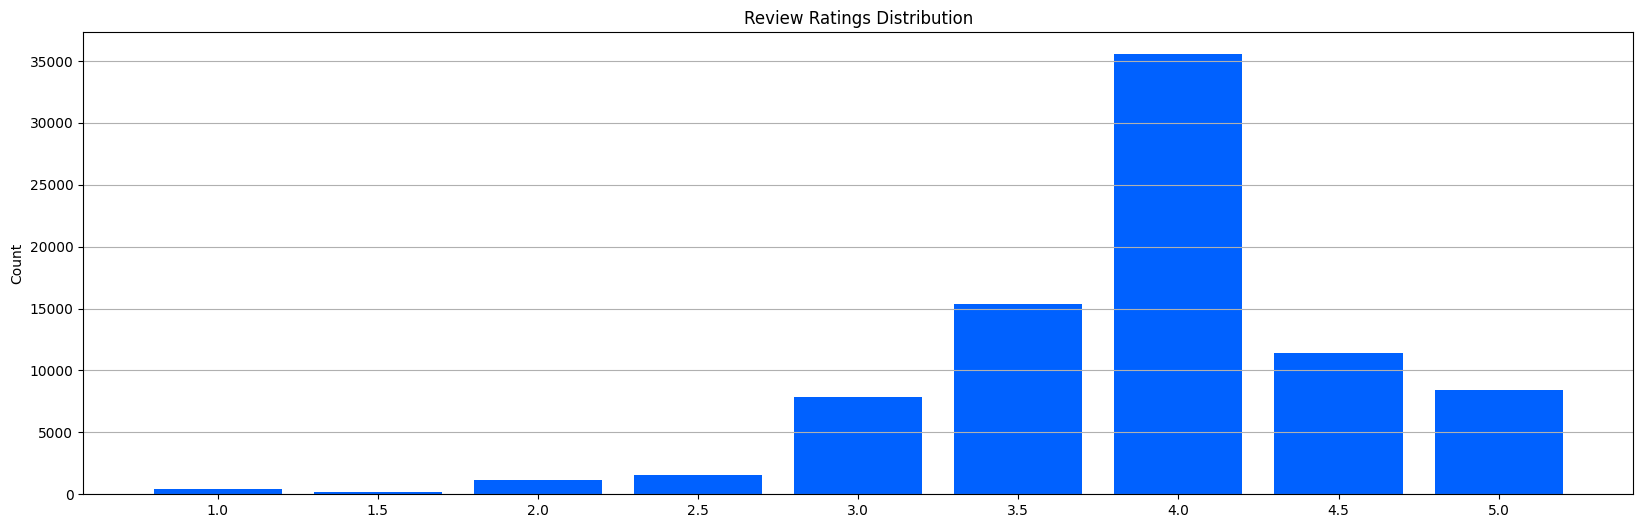

In [59]:
# Plotting
temp_df = review_df.copy()[['review_rating']]
temp_df['review_rating'] = temp_df['review_rating'].apply(lambda values: np.round(values * 2) / 2)

sorted_review_df = temp_df['review_rating'].value_counts().reset_index().sort_values(by='review_rating')
sorted_review_df['review_rating'] = sorted_review_df['review_rating'].astype(str)

plt.figure(figsize=(20, 6))
plt.bar(sorted_review_df['review_rating'], sorted_review_df['count'], color='#0061FF')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Review Ratings Distribution')
plt.grid(axis='y')
plt.show()

In [60]:
# create the labels to capture the broad sense: 0.5 were kept
review_df['review_rating_cat'] = review_df['review_rating'].apply(lambda values: np.round(values * 2) / 2)

#### d. Data types

##### feature_df

In [61]:
data_types = feature_df.dtypes.reset_index()
data_types.columns = ['feature', 'data-type']
data_types.set_index('feature')

,data-type
feature,
wine_id,int64
wine,object
winery,object
year,object
region,object
...,...
spices,bool
vegetal,bool
amount_flavor_words,int64


In [62]:
# categorical
cat_features = list(data_types[data_types['data-type'] == "object"]["feature"])
print(f'{len(cat_features)} categorical variables')

# numerical
numeric_features = list(data_types[data_types['data-type'] != "object"]["feature"])
print(f'{len(numeric_features)} numerical variables')

15 categorical variables
47 numerical variables


##### review_df

In [63]:
data_types = review_df.dtypes.reset_index()
data_types.columns = ['feature', 'data-type']
data_types.set_index('feature')

,data-type
feature,
wine_id,int64
review_id,int64
user_id,int64
review_rating,float64
review,object
createdat,object
review_referring_year,object
likes_on_review,int64
comments_on_review,int64


In [64]:
# extract the date
review_df[['date_review', 'time_review']] = review_df['createdat'].str.split('T', expand=True)

# extract the time 
review_df['time_review'] = review_df['time_review'].str.replace('.000Z', '', regex=False)

# drop unnecessary column
review_df.drop(columns = 'createdat', axis=1, inplace=True)

# change format to date 
review_df['date_review'] = pd.to_datetime(review_df['date_review'], format='%Y-%m-%d')

In [65]:
review_df['time_review'] = pd.to_datetime(review_df['time_review'], format='%H:%M:%S').dt.time

In [66]:
# categorical
cat_reviews = list(data_types[data_types['data-type'] == "object"]["feature"])
print(f'{len(cat_reviews)} categorical variables')

# numerical
numeric_reviews = list(data_types[data_types['data-type'] != "object"]["feature"])
print(f'{len(numeric_reviews)} numerical variables')

5 categorical variables
13 numerical variables


In [67]:
review_df.columns

Index(['wine_id', 'review_id', 'user_id', 'review_rating', 'review',
       'review_referring_year', 'likes_on_review', 'comments_on_review',
       'user_language', 'user_follower', 'user_following',
       'user_total_given_ratings', 'user_total_sum_ratings',
       'user_total_given_reviews', 'user_purchase_made', 'unique_id',
       'review_rating_cat', 'date_review', 'time_review'],
      dtype='object')

In [68]:
feature_df.to_csv('20231010_feature_cleaned.csv', index = False)

review_df.to_csv('20231010_review_cleaned.csv', index = False)

### **2. Data cleaning and preparation for the merged dataframe**

#### a. Data import & merge

In [69]:
data_directory

'/Users/lukas/OneDrive/01_Projects/Conduct your own end-to-end analytics project/Code/Upload'

In [70]:
# features
feature_df = pd.read_csv(path.join(data_directory, '20231010_feature_cleaned.csv'), low_memory=False)

# reviews
review_df = pd.read_csv(path.join(data_directory, '20231010_review_cleaned.csv'), low_memory=False)

In [71]:
# define a list for unique wine-id to analyze only reviews with the features
wine_feature_list = list(np.unique(feature_df['unique_id']))

review_df = review_df[review_df['unique_id'].isin(wine_feature_list)]

In [72]:
list(np.unique(review_df["wine_id"]))== list(np.unique(feature_df["wine_id"]))

True

In [73]:
# sanity check 
wine_review_list = list(np.unique(review_df['unique_id']))
wine_feature_list.sort()
wine_review_list.sort()

# created unique key 
print(f'match for created key:\t {wine_review_list == wine_feature_list}') 
# original wine id 
print(f'match for original key:\t {list(np.unique(review_df["wine_id"]))== list(np.unique(feature_df["wine_id"]))}')

match for created key:	 True
match for original key:	 True


In [74]:
# merge the data frames 
wine_df = pd.merge(feature_df, review_df, how='outer', on='unique_id')

#### b. Pre-processing data

In [75]:
wine_df.drop(columns=['wine_id_y'], inplace=True)

In [76]:
wine_df.rename(columns = {'wine_id_x': 'wine_id'}, inplace=True)

In [77]:
# drop the year and just rely on the comment referring year
wine_df.drop(columns=['year'], inplace=True)

wine_df.rename(columns = {'wine_id_x': 'wine_id', 'review_rating': 'rating', 'review_rating_cat': 'rating_label', 'review_referring_year': 'vintage'}, inplace=True)

In [78]:
# assess the length of the cleaned review
wine_df['review_len'] = wine_df['review'].astype(str).apply(len)

In [79]:
# assess the number of cleaned words 
wine_df['review_word'] = wine_df['review'].apply(lambda x: len(str(x).split()))

#### c. Product attributes

In [80]:
# Intrinsic Attributes
intrinsic_attributes = [
    'wine_style', 'wine_style_description', 'grapes','body_description',
    'acidity', 'sweetness', 'intensity', 'tannin', 'fizziness', 'alcohol', 'amount_grapes',
    'wine_type', 'vintage'
]

# Extrinsic Attributes
extrinsic_attributes = [
    'wine_id', 'wine', 'winery', 'region', 'ratings_average', 'ratings_number',
    'all_vintage_ratings_average', 'all_vintage_ratings_count', 'price', 'price_type',
    'interesting_facts', 'bottle_type', 'unique_id', 'has_wine_style_description',
    'has_interesting_facts', 'beef', 'mild and soft cheese', 'blue cheese', 'shellfish',
    'sweet desserts','veal', 'lean fish', 'appetizers and snacks', 'game (deer & vension)',
    'vegetarian', 'cured meat', 'mature and hard cheese', 'aperitif', 'lamb', 'fruity desserts',
    'pasta', 'pork', 'rich fish (salmon & tuna etc)', 'poultry','vegetal', 'earth', 'floral', 
    'tree_fruit', 'red_fruit', 'black_fruit', 'microbio', 'spices', 'citrus_fruit', 'non_oak', 'oak', 'dried_fruit',
    'tropical_fruit', 'amount_flavor_words', 'review_id', 'user_id','date_review', 'time_review', 'amount_food_words'
]

# Personal Attributes
personal_attributes = [
    'rating', 'review', 'likes_on_review', 'comments_on_review', 'user_language',
       'user_follower', 'user_following', 'user_total_given_ratings',
       'user_total_sum_ratings', 'user_total_given_reviews',
       'user_purchase_made', 'rating_label', 'review_len', 'review_word'
]

In [81]:
for element in wine_df:
    if element not in intrinsic_attributes+extrinsic_attributes+personal_attributes:
        print(element)

In [82]:
data = []

for attr in intrinsic_attributes:
    data.append(['intrinsic', attr])

for attr in extrinsic_attributes:
    data.append(['extrinsic', attr])

for attr in personal_attributes:
    data.append(['personal', attr])

df_attributes = pd.DataFrame(data, columns=['attribute_type', 'feature'])
df_attributes.head()  # Display the first few rows of the DataFrame

# Assigning colors to each attribute type
# Tableau color codes
color_map = {
    'intrinsic': '#1f77b4',  # Tableau Blue
    'extrinsic': '#ff7f0e',  # Tableau Orange
    'personal': '#7f7f7f'    # Tableau Grey
}

# Add a color column to the DataFrame
df_attributes['color'] = df_attributes['attribute_type'].map(color_map)
df_attributes.head()  # Display the first few rows of the DataFrame with colors

,attribute_type,feature,color
0,intrinsic,wine_style,#1f77b4
1,intrinsic,wine_style_description,#1f77b4
2,intrinsic,grapes,#1f77b4
3,intrinsic,body_description,#1f77b4
4,intrinsic,acidity,#1f77b4


In [83]:
df_attributes['color'].value_counts()

color
#ff7f0e    53
#7f7f7f    14
#1f77b4    13
Name: count, dtype: int64

In [84]:
df_attributes.to_csv('attribute_df.csv', index=False)

In [85]:
wine_df.to_csv('wine_df.csv', index=False)